In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [2]:
with open("cube/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in ["02", "3"]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [3]:
with open("cube/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (2, 8, 2)
objpoints: (2, 8, 3)


In [5]:
cam = 2

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
P = np.array([p1, p2], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

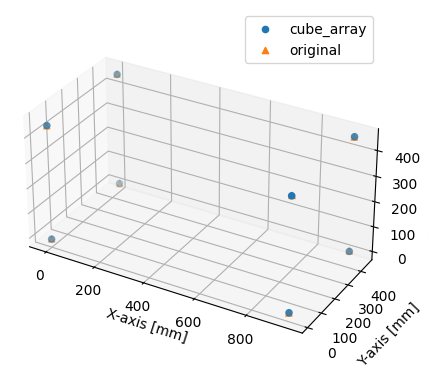

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [7]:
data_num = 0

camera_name1 = "0"
camera_name2 = "3"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")

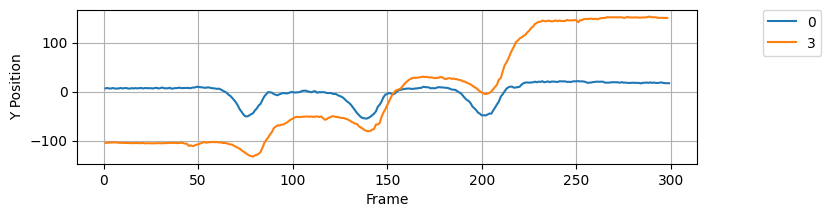

In [8]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"] - cam1_position[f"{name}_y"].mean(), label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"] - cam2_position[f"{name}_y"].mean(), label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [9]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_0"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_3"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1

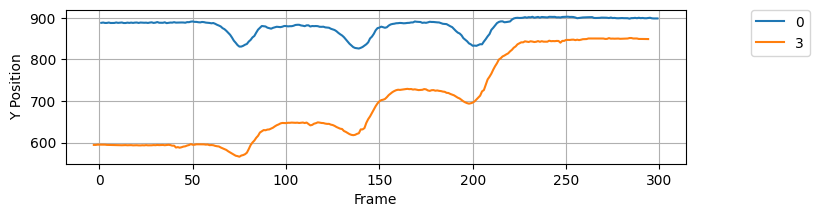

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [11]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2

In [12]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]

In [13]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)

In [14]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max())

print(min_frame, max_frame)

1.0 294.0


In [15]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

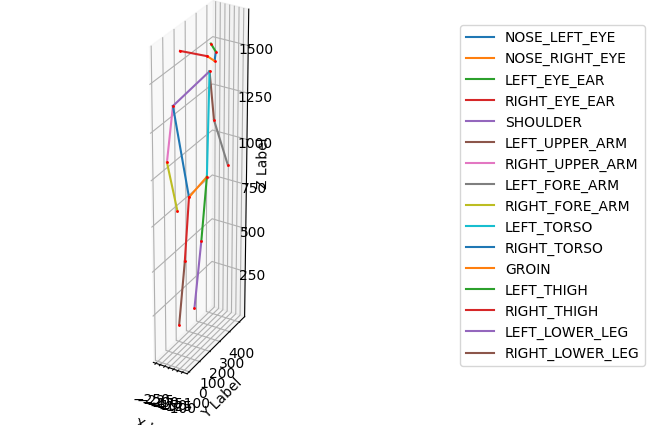

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [17]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,-85.999556,159.045876,1543.758067,-97.310730,189.702615,1574.686061,-104.378198,124.308989,1577.959875,-168.442226,...,478.015254,-210.058528,94.449044,463.153596,-248.057033,251.410474,90.408531,-240.727877,89.503687,89.387703
2,-86.271868,159.789138,1545.520123,-97.529301,190.228236,1577.359076,-102.450588,123.407683,1579.684352,-170.724529,...,476.318978,-208.108667,92.733065,462.455829,-248.349788,252.369469,89.199477,-241.095153,90.528265,88.111126
3,-85.711402,160.253104,1545.347822,-96.969939,190.692437,1577.185986,-101.887103,123.869857,1579.508595,-170.089126,...,478.276261,-207.400353,93.221089,465.412106,-247.696238,252.202277,91.051921,-240.421399,90.344993,90.030334
4,-86.981884,158.358103,1545.379356,-97.068789,191.647154,1577.146944,-101.995311,124.813857,1579.474818,-170.254586,...,480.241762,-207.507524,95.630612,465.353708,-245.548593,252.190479,91.774490,-240.637576,91.788435,87.759619
5,-86.740684,159.301100,1545.336170,-98.956832,194.242334,1577.118310,-103.949725,127.425217,1579.443253,-169.936904,...,481.816610,-207.219765,96.556886,465.843751,-245.254363,253.809824,90.546384,-241.579126,90.016789,87.939634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,3685.856674,706.790926,1496.321777,3474.032065,1061.654087,1516.516127,3807.377537,463.842142,1511.710082,4226.157098,...,443.809230,3780.787933,345.214383,461.191594,3774.821589,468.947330,80.329115,3775.144221,335.673691,92.589434
291,3682.508426,710.993925,1497.229406,3480.079094,1046.090822,1515.819584,3807.844585,461.871957,1510.116645,4226.883501,...,442.342433,3779.420264,350.669565,458.057903,3774.213628,470.862262,79.945870,3772.608962,342.826596,92.012262
292,3682.366674,712.458544,1497.491509,3481.895751,1043.139281,1517.242031,3813.571838,448.813471,1511.378983,4225.083492,...,443.412376,3780.033701,350.265416,459.400825,3774.273862,467.961069,80.557060,3773.611456,342.117624,90.132125


In [18]:
plot_3d_motion_exp(position_df/1000, output_name="camera03.html")